In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, MeanShift, estimate_bandwidth, KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [3]:
# Load the dataset
wine_df = pd.read_csv("WineQT.csv")

In [4]:
# Display the first few rows
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [8]:
# Drop the 'Id' column if it exists
if 'Id' in wine_df.columns:
    wine_df.drop('Id', axis=1, inplace=True)
features = wine_df.drop(columns=['quality', 'Id'], errors='ignore')

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [10]:
pca_95 = PCA(n_components=0.95)
pca_95_features = pca_95.fit_transform(scaled_features)

In [11]:
# Clustering - DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=4)
dbscan_labels = dbscan.fit_predict(pca_95_features)
dbscan_mask = dbscan_labels != -1
dbscan_score = silhouette_score(pca_95_features[dbscan_mask], dbscan_labels[dbscan_mask]) if len(set(dbscan_labels)) > 1 and np.sum(dbscan_mask) > 1 else -1

In [12]:
# Clustering - Mean Shift
bandwidth = estimate_bandwidth(pca_95_features, quantile=0.2, n_samples=300)
meanshift = MeanShift(bandwidth=bandwidth)
meanshift_labels = meanshift.fit_predict(pca_95_features)
meanshift_score = silhouette_score(pca_95_features, meanshift_labels) if len(set(meanshift_labels)) > 1 else -1

In [13]:
# Clustering - KMeans (use number of clusters from Mean Shift for consistency)
k = len(np.unique(meanshift_labels))
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(pca_95_features)
kmeans_score = silhouette_score(pca_95_features, kmeans_labels)


In [14]:
# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_features = tsne.fit_transform(pca_95_features)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [15]:
# Create final DataFrame
cluster_df = pd.DataFrame(pca_95_features, columns=[f'PCA{i+1}' for i in range(pca_95.n_components_)])
cluster_df['DBSCAN_Label'] = dbscan_labels
cluster_df['MeanShift_Label'] = meanshift_labels
cluster_df['KMeans_Label'] = kmeans_labels
cluster_df['TSNE1'] = tsne_features[:, 0]
cluster_df['TSNE2'] = tsne_features[:, 1]

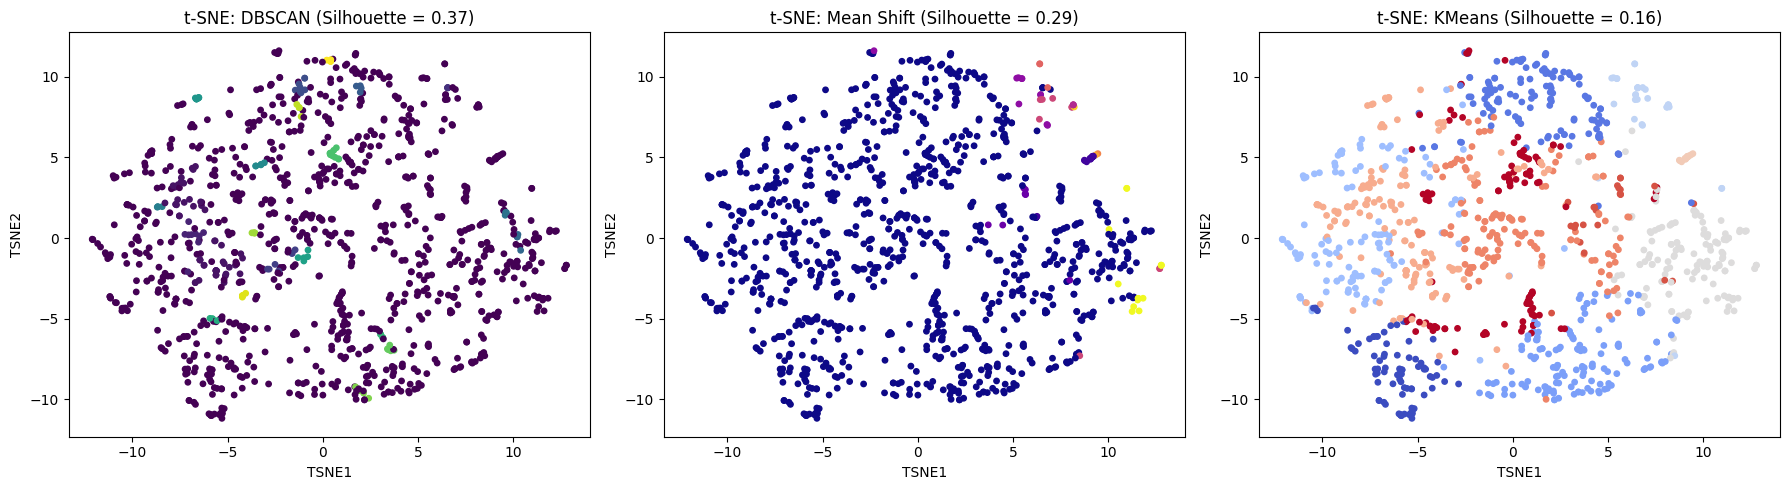

In [16]:
# Plot clustering results in t-SNE space
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(cluster_df['TSNE1'], cluster_df['TSNE2'], c=cluster_df['DBSCAN_Label'], cmap='viridis', s=15)
axes[0].set_title(f"t-SNE: DBSCAN (Silhouette = {dbscan_score:.2f})")
axes[0].set_xlabel("TSNE1")
axes[0].set_ylabel("TSNE2")

axes[1].scatter(cluster_df['TSNE1'], cluster_df['TSNE2'], c=cluster_df['MeanShift_Label'], cmap='plasma', s=15)
axes[1].set_title(f"t-SNE: Mean Shift (Silhouette = {meanshift_score:.2f})")
axes[1].set_xlabel("TSNE1")
axes[1].set_ylabel("TSNE2")

axes[2].scatter(cluster_df['TSNE1'], cluster_df['TSNE2'], c=cluster_df['KMeans_Label'], cmap='coolwarm', s=15)
axes[2].set_title(f"t-SNE: KMeans (Silhouette = {kmeans_score:.2f})")
axes[2].set_xlabel("TSNE1")
axes[2].set_ylabel("TSNE2")

plt.tight_layout()
plt.show()


In [6]:
# Check for null values
print(wine_df.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [ ]:
# Map wine quality to categories
wine_df['quality_grouped'] = wine_df['quality'].apply(
    lambda x: 'Low' if x <= 4 else ('Medium' if x <= 6 else 'High')
)

In [ ]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
wine_df['quality_grouped'] = le.fit_transform(wine_df['quality_grouped'])


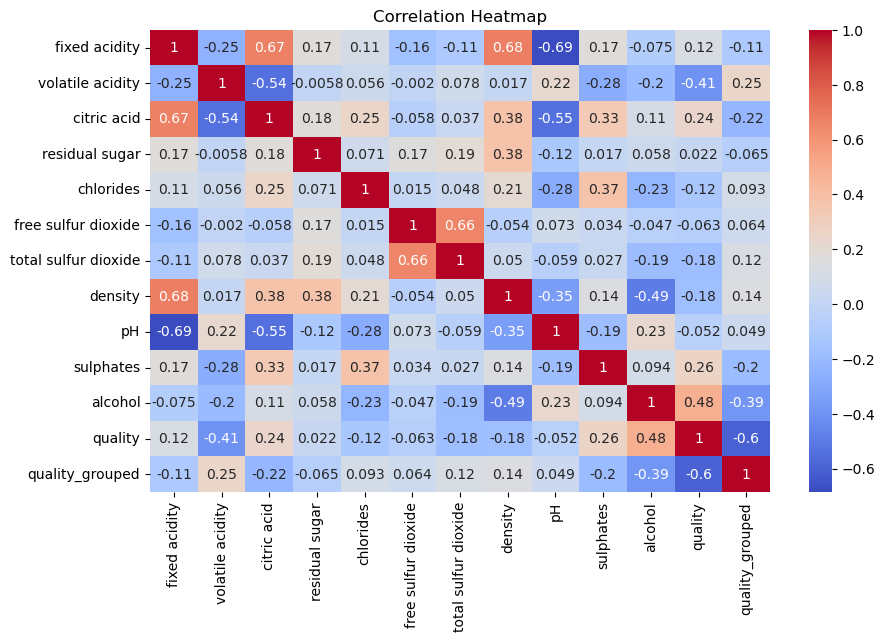

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(wine_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Select top 4 features based on correlation with quality
top_features = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid']


In [ ]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(wine_df[top_features])

In [ ]:
# Create linkage matrix for dendrogram
linked = linkage(X_scaled, method='ward')

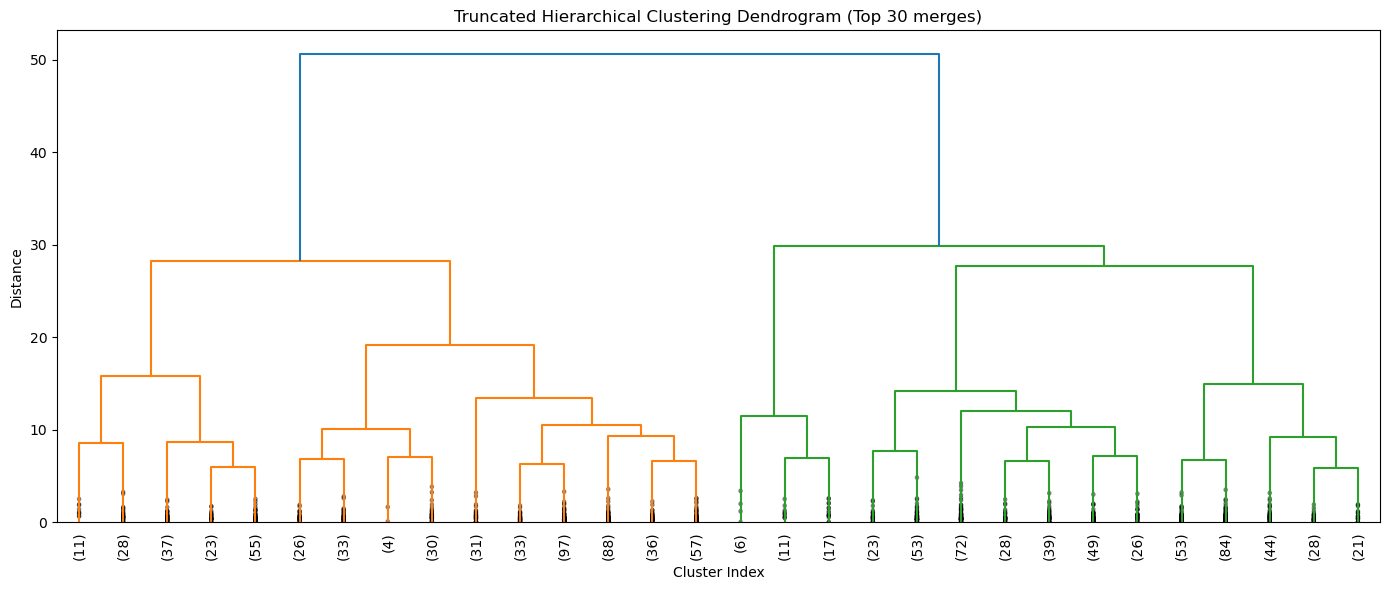

In [ ]:
# Plot truncated dendrogram for readability
plt.figure(figsize=(14, 6))

dendrogram(linked,
           truncate_mode='lastp',     # show only the last p merged clusters
           p=30,                       # adjust this number for more/less detail
           leaf_rotation=90.,
           leaf_font_size=10.,
           show_contracted=True)

plt.title('Truncated Hierarchical Clustering Dendrogram (Top 30 merges)')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


In [ ]:
# From dendrogram, let's assume 3 clusters
model = AgglomerativeClustering(n_clusters=3)
wine_df['cluster'] = model.fit_predict(X_scaled)

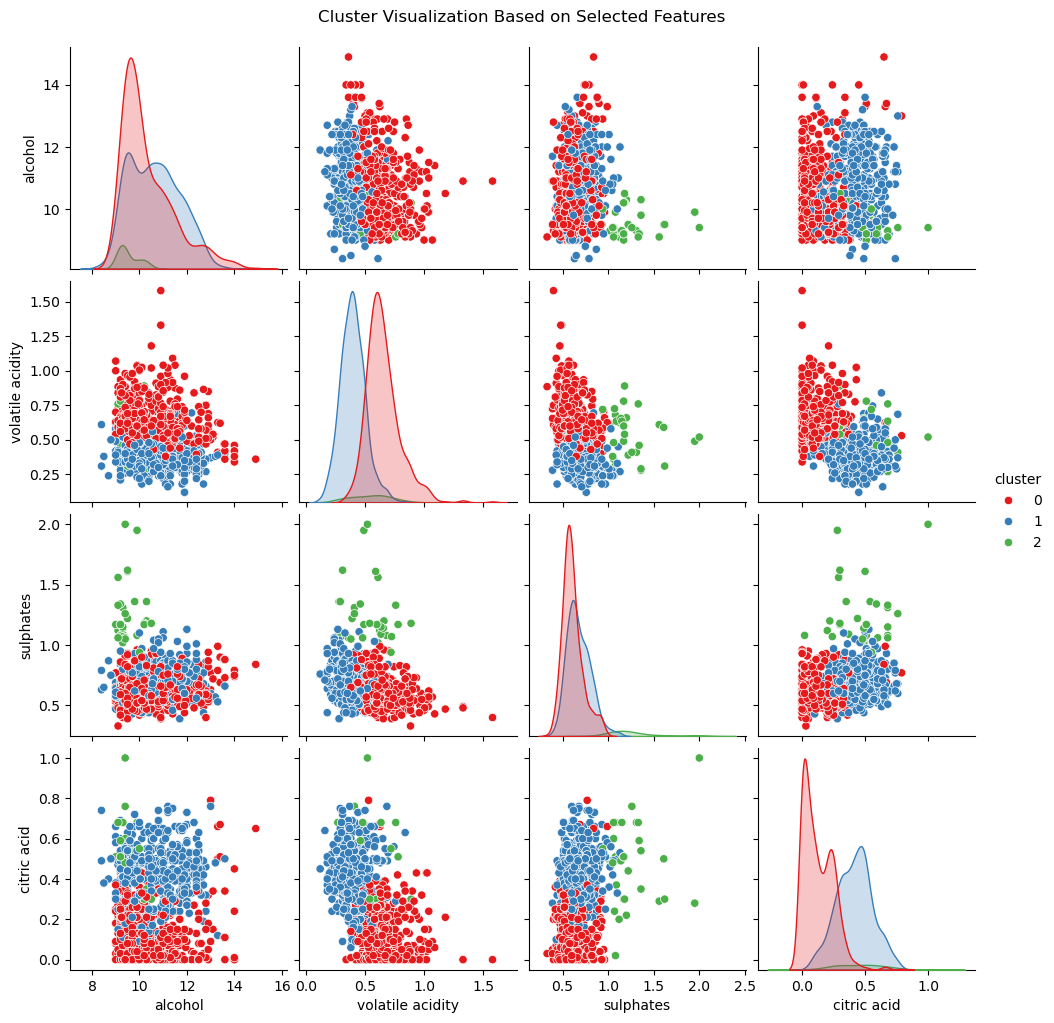

In [ ]:
# Visualize clusters with pairplot
sns.pairplot(wine_df[top_features + ['cluster']], hue='cluster', palette='Set1')
plt.suptitle("Cluster Visualization Based on Selected Features", y=1.02)
plt.show()


In [ ]:
# Analyze average values of each feature per cluster
cluster_summary = wine_df.groupby('cluster')[top_features].mean()
print("\nCluster Feature Averages:\n")
print(cluster_summary)


Cluster Feature Averages:

           alcohol  volatile acidity  sulphates  citric acid
cluster                                                     
0        10.332965          0.650577   0.605993     0.127674
1        10.624455          0.395548   0.676173     0.415212
2         9.544118          0.542500   1.271176     0.459706


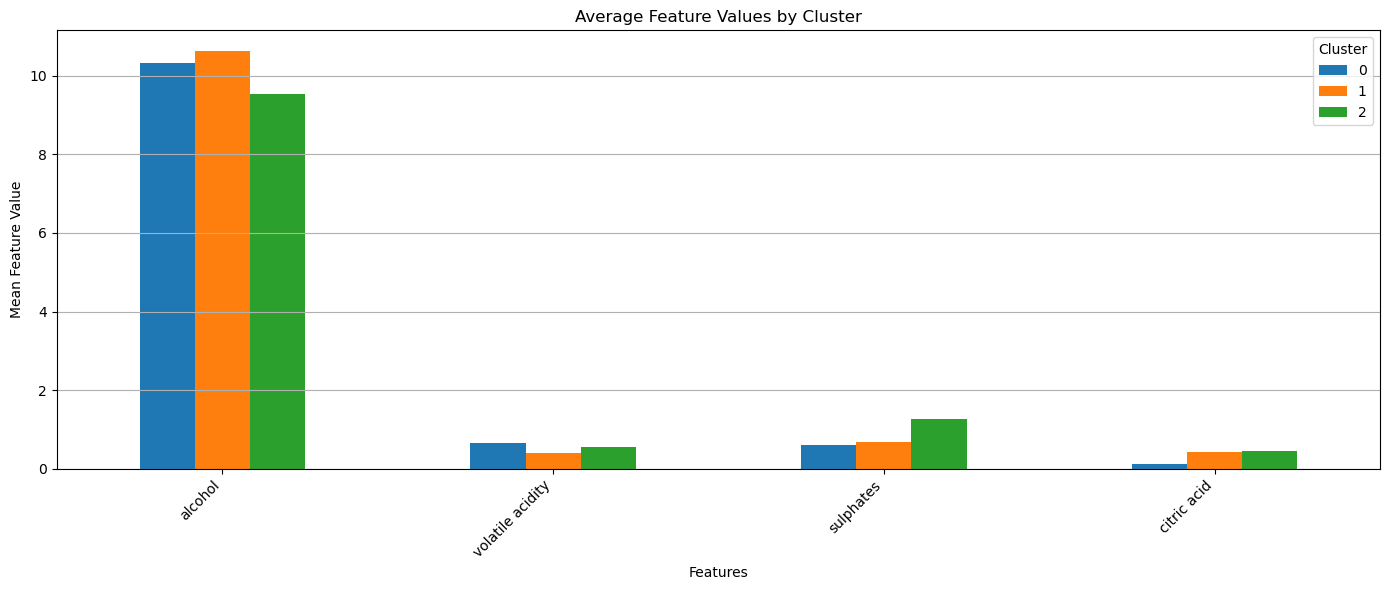

In [ ]:
# Better format for comparison: features on x-axis
cluster_summary.T.plot(kind='bar', figsize=(14, 6))

plt.title("Average Feature Values by Cluster")
plt.ylabel("Mean Feature Value")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [19]:
# Print final silhouette scores
print({
    "DBSCAN Silhouette (PCA 95%)": dbscan_score,
    "Mean Shift Silhouette (PCA 95%)": meanshift_score,
    "KMeans Silhouette (PCA 95%)": kmeans_score,
     })

{'DBSCAN Silhouette (PCA 95%)': np.float64(0.3696723812469153), 'Mean Shift Silhouette (PCA 95%)': np.float64(0.2943089586453141), 'KMeans Silhouette (PCA 95%)': np.float64(0.15897158555648713)}


In [ ]:
# Evaluate clusters by comparing with quality labels
contingency_table = pd.crosstab(wine_df['cluster'], wine_df['quality_grouped'])
print("\nContingency Table (Cluster vs Quality Grouped):\n")
print(contingency_table)


Contingency Table (Cluster vs Quality Grouped):

quality_grouped    0   1    2
cluster                      
0                 34  28  527
1                123   8  389
2                  2   3   29


In [ ]:
# Final thoughts
print("\nConclusion:")
print("- Hierarchical Clustering was performed on the top 4 correlated features.")
print("- A dendrogram was used to determine the number of clusters.")
print("- The resulting clusters show some alignment with wine quality groups, suggesting clustering has some predictive structure.")



Conclusion:
- Hierarchical Clustering was performed on the top 4 correlated features.
- A dendrogram was used to determine the number of clusters.
- The resulting clusters show some alignment with wine quality groups, suggesting clustering has some predictive structure.
